In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate
from matplotlib import cm
from numpy import fft

from matplotlib.animation import FuncAnimation, PillowWriter 
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import time

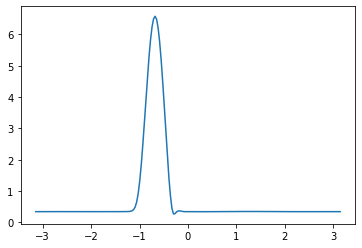

In [4]:
z = np.load('full_data_soliton/z_valuesforsoliton_march1.npy')
soliton_ic = np.load('full_data_soliton/soliton_profile_march1_static.npy')
plt.plot(z, soliton_ic)

4.725175004924716
0.3141592653589796
Solved deterministic , (200, 100)


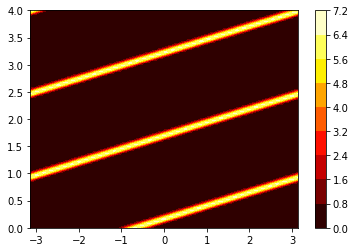

In [5]:
#definitions: 
alpha = .95; epsilon = .1; L = np.pi*2; D = 0.6 #very intereting with D=0.5 (which is the same as Ma=1/4) and D = 0.6
Ma  = (1-D)/2
I_0 = 1; remainder = Ma/I_0**2
N = len(z); n = np.arange(N); n[int(N/2)+1:] -= N

def RHS_not_stoch(time,eta):
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

T = 4
t = np.linspace(0,T, 100)
t_eval = np.linspace(0,T, 10)
delta_t = t[1]-t[0]

t_span = (0,T)
u0 = soliton_ic
print(np.trapz(u0, z))
print(L*(1-alpha))
result_ivp_determininistic = scipy.integrate.solve_ivp(RHS_not_stoch, t_span, u0, 'BDF', atol = 1e-2, t_eval =t)
u_det = result_ivp_determininistic.y
print('Solved deterministic ,', np.shape(u_det))
max_value_deterministic = np.max(u_det, axis=0)[-1]
Z,T = np.meshgrid(z,t)
plt.contourf(Z,T,u_det.T, cmap ='hot')
plt.colorbar()
plt.show()
np.save(f'full_data_soliton/det_soliton_data_march1_alpha_{alpha}_epsilon_{epsilon}_Ma_{Ma}.npy', u_det)
np.save(f'full_data_soliton/times_soliton.npy', t_span)
np.save(f'full_data_soliton/collocation_points_soliton.npy', z)

In [32]:
vol = 0.05;
Number_of_iter = 100
t_eval = np.linspace(0,T, 10)
max_values = np.zeros(Number_of_iter)
mean_current = np.zeros(Number_of_iter)
results_array = np.zeros((np.shape(u_det)[0], np.shape(u_det)[-1], Number_of_iter))
currents_array = np.zeros((len(t), Number_of_iter))
N = len(z); n = np.arange(N); n[int(N/2)+1:] -= N
st = time.time(); stc = time.process_time()
print(vol)
print('Started iterating')
for j in range(Number_of_iter):
    #generate the Brownian Motion for the current 

    I_t = np.cumsum(np.random.normal(loc=0.0, scale = vol*delta_t, size=(len(t), ))) + I_0
    currents_array[:,j] = I_t
    mean_current[j] = np.mean(I_t)
    def RHS_no_current(time,eta):
        I = np.interp(time, t,I_t)
        Ma = remainder*I**2
        eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
        eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
        detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
        return detadt
    result_ivp = scipy.integrate.solve_ivp(RHS_no_current, t_span, u0, 'BDF', atol = 1e-2, t_eval = t)
    max_values[j] = np.max(result_ivp.y, axis = 0)[-1]
    results_array[:,:, j] = result_ivp.y
    
    if (j+1) % 10 == 0:
        print('Solved stoch,', np.shape(result_ivp.y), int(100*(j+1)/Number_of_iter), ' %', time.time()-et, ' seconds')
    del I_t
    del RHS_no_current
    del result_ivp
etc = time.process_time()

# get execution time
res = etc - stc
print(f'CPU time = {res}. Per iteration = {round(res/Number_of_iter, 3)}')
et = time.time()

# get the execution time
elapsed_time = et - st

print(f'Wall time = {elapsed_time}. Per iteration = {round(elapsed_time/Number_of_iter, 3)}')
np.save(f'full_data_soliton/data_soliton_march2_vol_{vol}_alpha_{alpha}_epsilon_{epsilon}_Ma_{Ma}_N_iter_{Number_of_iter}.npy', results_array)
np.save(f'full_data_soliton/currents_soliton_march2_vol_{vol}_alpha_{alpha}_epsilon_{epsilon}_Ma_{Ma}_N_iter_{Number_of_iter}.npy', currents_array)



0.05
Started iterating
Solved stoch, (200, 100) 10  % 49002.73085784912  seconds
Solved stoch, (200, 100) 20  % 49195.89458203316  seconds
Solved stoch, (200, 100) 30  % 49388.677471876144  seconds
Solved stoch, (200, 100) 40  % 49584.270148038864  seconds
Solved stoch, (200, 100) 50  % 49776.217813014984  seconds
Solved stoch, (200, 100) 60  % 49990.2662229538  seconds
Solved stoch, (200, 100) 70  % 50186.47300696373  seconds
Solved stoch, (200, 100) 80  % 50386.03152894974  seconds
Solved stoch, (200, 100) 90  % 50578.584782123566  seconds
Solved stoch, (200, 100) 100  % 50782.441682100296  seconds
CPU time = 9380.455679000002. Per iteration = 93.805
Wall time = 1974.6295149326324. Per iteration = 19.746


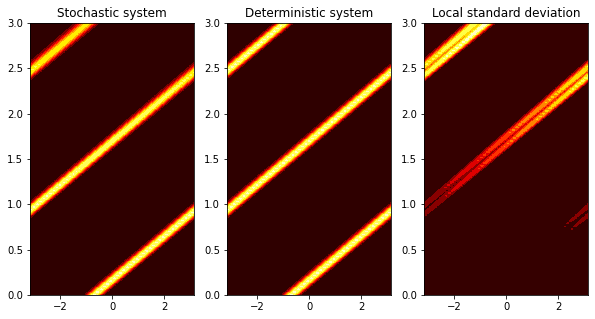

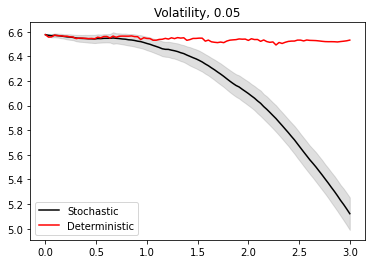

In [33]:
mean_result = np.mean(results_array, axis=-1)
std_result = np.std(results_array, axis=-1)
fig, ax=plt.subplots(nrows=1, ncols = 3, figsize = (10,5))
Z,T = np.meshgrid(z,t)
ax[0].contourf(Z,T,mean_result.T, cmap ='hot')
ax[0].set_title('Stochastic system')
ax[1].contourf(Z,T,u_det.T, cmap ='hot')
ax[1].set_title('Deterministic system')
ax[2].contourf(Z,T,std_result.T, cmap ='hot')
ax[2].set_title('Local standard deviation')
plt.savefig('stoch_averaging.jpg')
#plt.colorbar()
plt.show()

plt.plot(t, np.max(mean_result, axis=0), color ='black', label ='Stochastic')
plt.fill_between(t, np.max(mean_result, axis=0)+np.std(np.max(results_array, axis=0), axis=-1), 
         np.max(mean_result, axis=0)-np.std(np.max(results_array, axis=0), axis=-1), color ='grey', alpha = 0.25)
plt.title(f'Volatility, {vol}')
plt.plot(t, np.max(u_det, axis=0), color='red', label='Deterministic')
plt.legend()

In [34]:
#plt.plot(t, results_array[])

Threshold sigma. If sigma is small
$$I=I_0 + \epsilon W $$
if epsilon is zero -> solitary travelling wave. If you look for solution where 
$$u=U + \epsilon u_1$$
u_1 is stochastic. $u_1(x-ct, t)$ Equation for $u_1$ will be linear. 
Theory for PDEs were noise is dissipating. 

In [66]:
vol_zero_point_1 = np.load('full_data_soliton/data_soliton_march12_vol_0.005_alpha_0.95_epsilon_0.1_Ma_0.2_N_iter_100.npy')
np.shape(vol_zero_point_1)

(200, 100, 100)

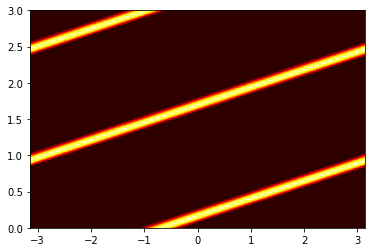

In [45]:
plt.contourf(Z,T, u_det.T, cmap='hot')

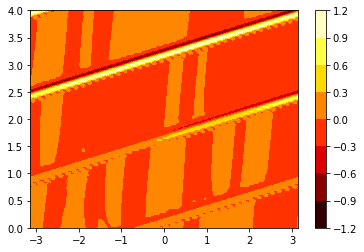

In [72]:
difference = np.mean(vol_zero_point_1, axis=-1)-u_det
plt.contourf(Z,T, difference.T, cmap='hot'); plt.colorbar()

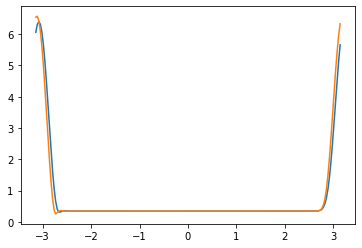

In [73]:
plt.plot(z, np.mean(vol_zero_point_1, axis=2)[:,-1])
plt.plot(z, u_det[:,-1])

In [63]:
print(np.shape(results_array))
np.save('full_data_soliton/test.npy', results_array)
np.shape(np.load('full_data_soliton/test.npy'))

(200, 100, 100)


(200, 100, 100)

In [64]:
vol_zero_point_1

array([[0.9999949 , 1.00005069, 1.00024056, ..., 0.99981392, 1.00019742,
        1.00026479],
       [0.99997863, 1.00034267, 1.00050017, ..., 1.00003565, 1.00022896,
        1.00025723],
       [0.99966005, 1.00044249, 1.00009171, ..., 1.00003451, 1.00030849,
        1.00042553],
       ...,
       [1.00105336, 1.0000519 , 0.99889419, ..., 1.00072245, 0.99724682,
        1.00117632],
       [1.00109514, 0.9999279 , 0.99878768, ..., 1.00103842, 0.99741598,
        1.00123987],
       [1.00134042, 1.00019465, 0.99882233, ..., 1.00087762, 0.99747655,
        1.00093857]])

In [8]:
import scipy


print(scipy.__version__)
print(scipy.__file__)
print(scipy.__path__)
print(dir(scipy))

1.7.1
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py
['/Users/javier/opt/anaconda3/lib/python3.9/site-packages/scipy']
['test']
